# Earthquake Data Analysis
by Rosset Lorenzo, Simionato Giuseppe, Sinigaglia Nicholas and Zanola Andrea

The main target of this project is to study how earthquakes work and try to verify statistical distributions used to describe their behaviour, as for example the Gutenberg–Richter Law and the Omori Law of aftershocks. \
The dataset used for this analysis is composed of 110271 events detecteced in Southern California in a period of time that goes from Jan 1st 1982 to Jun 29th 2011.

More in detail, for every earthquake in the catalog 7 features are given in 7 columns:
- 1st column contains the index of the event, from 0 to 112070;
- 2nd column contains the index of the previous event that triggered the considered one, index is -1 if no ancestor is found. These index are associated to earthquakes by an algorithm based on pandemic models;
- 3rd column contains the time of the event, in seconds, from  0:00 of Jan 1st, 1982;
- 4th column contains the magnitude of the event;
- 5th, 6th and 7th columns contain the x,y,z euclidean coordinates of the event. These coordinates are used in analysis to obtain latitude, longitude and depth of every event.

In [1]:
import numpy as np
import math
import pandas as pd
import pandas_bokeh
import matplotlib.pyplot as plt
import datetime
import imageio
import networkx as nx
import os
import seaborn as sns
import IPython as ip
from matplotlib.ticker import MultipleLocator
from scipy import optimize,stats
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.transform import factor_cmap, factor_mark, linear_cmap, log_cmap
from bokeh.palettes import Spectral6
from bokeh.models import markers, Segment, Plot
from bokeh.models.expressions import CumSum

output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv('SouthCalifornia-1982-2011_Physics-of-Data.dat', sep=' ', names=['n','pointer', 't', 'mag', 'x', 'y', 'z'])
df['date'] = pd.to_datetime(df['t'], unit='s', origin='01/01/1982')
df=df.sort_values(by='t')

df.head()

,n,pointer,t,mag,x,y,z,date
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602,1982-01-01 00:00:00.000000000
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373,1982-01-01 10:08:21.390720010
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232,1982-01-01 10:24:48.277440012
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479,1982-01-01 13:19:42.516480029
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546,1982-01-01 16:44:28.570559978


The following functions allow to convert the cartesian coordinates in latitude, longitude and depth, and also in the Mercator coordiante system using the Elliptical Mercator Projection.

In [ ]:
def merc_x(lon):
  r_major=6378137.000
  return r_major*math.radians(lon)

def merc_y(lat):
  if lat>89.5:lat=89.5
  if lat<-89.5:lat=-89.5
  r_major=6378137.000
  r_minor=6356752.3142
  temp=r_minor/r_major
  eccent=math.sqrt(1-temp**2)
  phi=math.radians(lat)
  sinphi=math.sin(phi)
  con=eccent*sinphi
  com=eccent/2
  con=((1.0-con)/(1.0+con))**com
  ts=math.tan((math.pi/2-phi)/2)/con
  y=0-r_major*math.log(ts)
  return y

In [ ]:
R = 6371000. #Earth radius
df['lat'] = np.arcsin(df['z']/R)*180./np.pi
df['long'] = np.arctan2(df['y'], df['x'])*180./np.pi
df['dep'] = R-np.sqrt(df['x']**2+df['y']**2+df['z']**2)
df['x_merc'] = df['long'].apply(merc_x)
df['y_merc'] = df['lat'].apply(merc_y)
#df.describe()

## Earthquakes visualization on the map

In [ ]:
tile_provider = get_provider(CARTODBPOSITRON)
x_range, y_range = (-13600000, -12500000), (3480000, 4500000)
p1 = figure(x_range=x_range, y_range=y_range,
           x_axis_type='mercator', y_axis_type='mercator', title='Map of earthquake distribution')
p1.add_tile(tile_provider)
p1.title.text_font_size = "30px"

#Creating a copy of the data for plotting
df1 = df.sort_values(by='mag') #sorting w.r.t. magnitude for better visualization
df1['mag'] = df1['mag'].round(0) #round mag values
df1['mark_size'] = df1['mag']**1.4
df1['alpha'] = df1['mag']/10.

mapper = log_cmap(field_name='mag', palette=Spectral6, low=2, high=7)
p1.scatter('x_merc', 'y_merc', source=df1, legend_field='mag', fill_alpha='alpha',
          size='mark_size', fill_color=mapper, line_color=None)
show(p1)

In order to visualize events over time 2D gifs are realized. They represent only a small interval of time compared to the almost 30 years covered by dataset, but are useful to visualize concatenation of earthquakes and how unexpected a main event can be (as the 28 June 1992 earthquake).

Every earthquake is shown as a red dot with size proportional to magnitude and that fades while time moves forward. \
The x and y coordinates used are respectevely longitude and latitude.

In [ ]:
# GIF CREATION
def gif_maker(df,data,n_frames,dt,index_min,index_max,gif_name):
# df = dataframe
# dt = time between two consecutive frames
# data = gif initial data 
# n_frames = number of frames
# index_min , index_max = parameters used for read only the part of dataset that cointains the event of interests. 
# They are choosed afterwards and improve performances

    # offset used to convert seconds in mm/dd/yyyy 
    T0_dataset = datetime.datetime(1982, 1, 2, 2, 0)
    delta_T = (T0_dataset - datetime.datetime(1970,1,1)).total_seconds()
    # gif initial time
    t0 = (data - T0_dataset).total_seconds()
    
    # data needed
    T = np.array(df["t"].tolist())
    M = np.array(df["mag"].tolist())
    Lat = np.array(df["lat"].tolist())
    Long = np.array(df["long"].tolist())

    frames = []
    for step in range(n_frames):
        x_points = []
        y_points = []
        size_points = []
        alpha_points = []
        n_events = 0

        # looking over all dataset is not necessary, for this reason index_min and index_max are used
        for i in range(index_min, index_max,1):
    
            # also events "in the past" are registred in order to make them fade using alpha parameter 
            if(T[i]>(step-6)*dt+t0 and T[i]<(step+1)*dt+t0):
                x_points.append(Long[i])
                y_points.append(Lat[i])
                # stronger earthquakes have bigger dots
                size_points.append((M[i]-0.75)**3.33)
                n_events = n_events + 1 
                # alpha parameter is associated, new events have aplha = 1 and are the most visible
                if(T[i]>(step-6)*dt+t0 and T[i]<(step-5)*dt+t0):     alpha_points.append(0.1)
                elif(T[i]>(step-5)*dt+t0 and T[i]<(step-4)*dt+t0):   alpha_points.append(0.2)
                elif(T[i]>(step-4)*dt+t0 and T[i]<(step-3)*dt+t0):   alpha_points.append(0.3)
                elif(T[i]>(step-3)*dt+t0 and T[i]<(step-2)*dt+t0):   alpha_points.append(0.4)
                elif(T[i]>(step-2)*dt+t0 and T[i]<(step-1)*dt+t0):   alpha_points.append(0.6)
                elif(T[i]>(step-1)*dt+t0 and T[i]<(step)*dt+t0):     alpha_points.append(0.8)
                elif(T[i]>(step)*dt+t0 and T[i]<(step+1)*dt+t0):     alpha_points.append(1)
         
        # implementin colors (red)
        rgba_colors = np.zeros((n_events,4))
        rgba_colors[:,0] = 1
        rgba_colors[:, 3] = alpha_points 

        # adding background, which has same x_range and y_range in term of Lat and Long
        img = plt.imread("gif_background.png")
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img, extent=[-122.8, -113.46, 29.8, 38])

        # creating frame, which is a graph
        ax.scatter(x=x_points,y=y_points,s=size_points,color=rgba_colors)
        name = str(step) + ".png"
        title = datetime.datetime.fromtimestamp(delta_T+t0+(step+1)*dt).strftime("%B %d, %Y %H:%M:%S")
        ax.set_title(title)
        ax.set_xlim(-122.8,  -113.46)
        ax.set_ylim(29.8, 38)
        fig.savefig(name)
        plt.clf()
        plt.close()
    
        # adding file as gif name
        frames.append(name)
        frames.append(name)
        
    # creating gif    
    with imageio.get_writer(gif_name, mode='I') as writer:
        for filename in frames:
            image = imageio.imread(filename)
            writer.append_data(image) 
    # deleting file  
    for file in set(frames):
        os.remove(file)

In [ ]:
# with these parameters we can see 28 June 1992 earthquake in detail 
gif_maker(df,datetime.datetime(1992, 6, 27, 20, 0),70,1800,35000,50000,'June_1992_detailed_earthquake.gif')
ip.display.Image('June_1992_detailed_earthquake.gif')

# with these parameters we can see 22 April 1992 foreshocks  
#gif_maker(df,datetime.datetime(1992, 4, 13, 20, 0),60,40000,35000,40000,'April_1992_foreshocks.gif')
#ip.display.Image('April_1992_foreshocks.gif')

# with these parameters we can see 28 June 1992 earthquake on a larger time scale
#gif_maker(df,datetime.datetime(1992, 6, 20, 0, 0),70,42000,35000,51000,'June_1992_earthquake.gif')
#ip.display.Image('June_1992_earthquake.gif')

## Frequency plot
An interesting feature we can visualize is the distribution of the number of events over time. In the plot below is shown also the magnitude of the single earthquakes

In [ ]:
mag_mask = df['mag'] > 3
c_index = df['mag'][mag_mask].round(0).astype('int32').values - 2
spectral6 = np.asarray(Spectral6)

gridsize = (3, 1)
fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
ax1_color = 'xkcd:coral'
ax1.plot(df['date'], df['n'], lw=2, c= ax1_color)
#ax1.grid(ls='--')
ax1.set_ylabel('$Cumulative~sum$', size=15, color=ax1_color)
ax1.tick_params(axis='y', labelcolor=ax1_color)

ax2 = ax1.twinx()
ax2_color = 'xkcd:peach'
ax2.set_ylabel('$Number~of~events$', color=ax2_color, size=15)
ax2.hist(df['date'], histtype='step', bins=29*365, color=ax2_color);
ax2.tick_params(axis='y', labelcolor=ax2_color)

ax3 = plt.subplot2grid(gridsize, (2, 0))
ax3.scatter(df['date'][mag_mask], df['mag'][mag_mask], c=spectral6[c_index])
ax3.vlines(df['date'][mag_mask], 0, df['mag'][mag_mask], colors=spectral6[c_index])
ax3.set_yscale('log')
ax3.set_xlabel('$Year$', size=15)
ax3.set_ylabel('$log(m)$', size=15);

It can be easily seen how soon after a very powerful earthquake the density of events over time suddenly increases. This is a clear sign of the fact that earthquackes are correlated over space and time, and tend to organize in swarms.

## Networks
In what follows we are going to visualize the hierarchic networks that arise from the two main events of the dataset

In [ ]:
def get_swarm(df, date_range, magth, central_event):
    mask1 = (df['date'] > date_range[0]) & (df['date'] < date_range[1]) & (df['mag'] > magth)
    dn = df[mask1]
    net = nx.from_pandas_edgelist(dn, source='n', target='pointer', create_using=nx.MultiGraph())
    main_nodes = nx.node_connected_component(net, central_event)   #nodes of the connected component of the central event. Needs to be converted
    main_net_temp = nx.subgraph(net, main_nodes)                   #network of the principal connected component
    df_mask = np.asarray(nx.nodes(main_net_temp))                  #list of nodes of the connected components
    df_mask = np.delete(df_mask, df_mask == -1)
    main_df = df.loc[df_mask]                                      # df with just the interesting nodes
    return main_df

In [ ]:
def network(df, date_range, magth, central_event, directed=False):
    main_df = get_swarm(df, date_range, magth, central_event)
    kind = 0
    if (directed):
        kind = nx.MultiDiGraph()
    else: kind = nx.MultiGraph()
    main_net = nx.from_pandas_edgelist(main_df, source='pointer', target='n', create_using=kind)
    colors = main_df['mag'].round(0)
    colors = colors.reindex(main_net.nodes()) # this is needed for assigning each node to the corresponding color
    return (main_net, colors)

In [ ]:
net1, colors1 = network(df, ('01/05/1992', '01/05/1993'), 3.7, 39805)
net2, colors2 = network(df, ('01/09/1999', '01/09/2000'), 3.5, 75422)
fig_net = plt.figure(figsize=(16,8))
fig_net.add_subplot(121)
nx.draw(net1, node_size=30, node_color=colors1, cmap=plt.cm.viridis)
fig_net.add_subplot(122)
nx.draw(net2, node_size=50, node_color=colors2, cmap=plt.cm.inferno)

# Originshock- Foreshock - Aftershock - GR

The main goal of this section is to study the behaviour of the magnitude considering different types of earthquakes. It's known in literature that exist different phases in the dynamic of an earthquake:
1. At the beginning, due to the stress between different plates an origin event is produced and here we will call it Originshock. 
2. Afer the origin an earthquake swarm starts, and maybe it will produce a Mainshock; these earthquakes are called Foreshocks in general characterized as "mild tremors".
3. Then, after the main, another earthquake swarm starts and these shocks are called Aftershocks. (scosse di assestamento)
4. If we consider all these earthquakes, without any differences, then the Gutenberg-Richter Law should be displayed.

#### Notation:
- Originshocks, all the earthquakes labeled as -1.
- Mainshocks, all the earthquakes with a magnitude above some threshold $m_{th}~$.
- Foreshocks, all the earthquakes in between Origins and Mains.
- Aftershocks, only the first generation of earthquakes produced by the Mains.

In [3]:
#------------Back Tree Algorithm---------------
def bta(mth):
    mask=(df['mag']>=mth) & (df['pointer']!=-1)
    i1 = df['pointer'][mask].to_numpy()
    origin=[]
    originv=[]
    for i in range(len(i1)):
        mask1=[]
        mask1=[i1[i]]
        while mask1[-1]!=-1:
            i2=df['pointer'][mask1[-1]] 
            mask1.append(i2)
        origin=np.insert(origin,0,mask1[-2])
        originv=np.insert(originv,0,mask1[:-1])
    origin=np.flip(origin)
    originv=np.unique(np.flip(originv))#tutti gli indici (no doppioni) che portano a ritroso all'evento generatore
    return origin, originv

#other useful function for fit
def q(x,a,b,c):
    q=a+b*x+c*x**2
    return q
def f(x,a,b):
    f=a+b*x
    return f
#function that helps to plot the last figures
def s(i,j):
    if i==1 and j==0:
     p=2
    elif i==1 and j==1:
     p=3
    else:
     p=i+j
    return p

---Fit Parameters with Errors Originshock---
a=2.07 +-0.06
b=-0.99 +-0.01
r=-0.9987
---Fit Parameters with Errors 3P Foreshock---
a=-0.33 +-0.20
b=0.33 +-0.10
c=-0.09 +-0.01
---Fit Parameters with Errors 2P Foreshock---
a=1.24 +-0.14
b=-0.47 +-0.03
r=-0.9666
Cv=0.0000 % from Fisher-Test
---Fit Parameters with Errors Aftershock---
a=2.22 +-0.07
b=-0.98 +-0.01
r=-0.9980
---Fit Parameters with Errors Gutenberg-Richter Law---
a=2.28 +-0.04
b=-1.04 +-0.01
r=-0.9994


Loading BokehJS ...

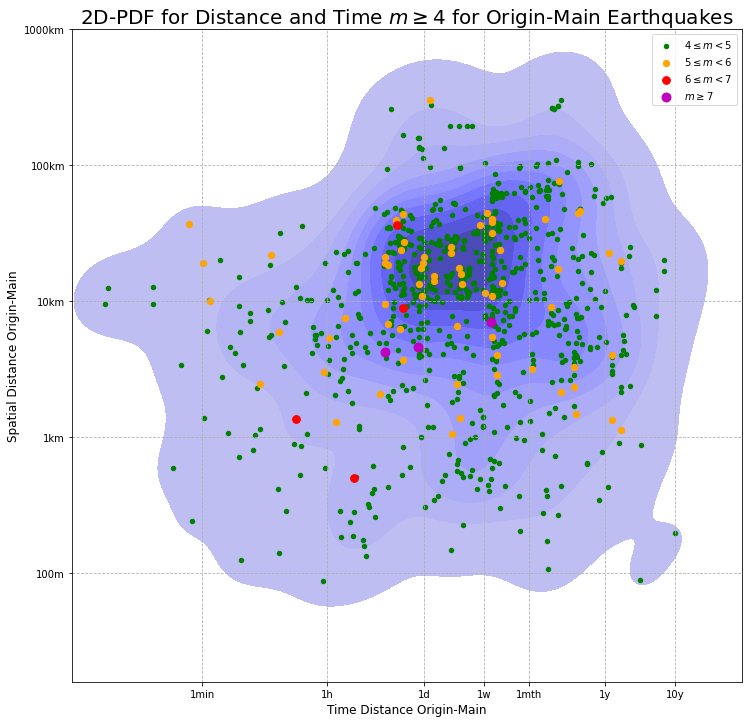

In [24]:
#--------------------------------------ORIGINSHOCK---------------
fig1, ax1 = plt.subplots(figsize=(12,12))
binss=np.linspace(2,7,21)
counts1, bins1,_ = ax1.hist(df['mag'][df['pointer']==-1], bins=binss,visible=0,density=1,cumulative=-1)
mask=counts1>0
logmB=np.log10(counts1[mask])
xB=((bins1[:-1]+bins1[1:])/2)[mask]
B=optimize.curve_fit(f,xB,logmB,p0=[6,-1])  #poisson error is assumed sigma=counts1[mask]**(-0.5)
resB = stats.linregress(xB, logmB)
print('---Fit Parameters with Errors Originshock---')
print('a=%.2f'%B[0][0],'+-%.2f'%B[1][0,0]**0.5)
print('b=%.2f'%B[0][1],'+-%.2f'%B[1][1,1]**0.5)
print('r=%.4f'%resB.rvalue)

#---------------------------------ORIGIN-MAIN PDF---------------
mth=4  #---CHOOSE MTH HERE-----
origin,_ =bta(mth)#we call the back tree-alg
mask=(df['mag']>=mth) & (df['pointer']!=-1)  
dtmc=df['t'][mask].to_numpy()-df['t'][origin].to_numpy()
x1=(df['x'][mask].to_numpy()-df['x'][origin].to_numpy())**2
y1=(df['y'][mask].to_numpy()-df['y'][origin].to_numpy())**2
z1=(df['z'][mask].to_numpy()-df['z'][origin].to_numpy())**2
drmc=(x1+y1+z1)**0.5
dfr=pd.DataFrame({'dtmc': dtmc/(60*60*24), 'drmc': drmc/1000,'mag':df['mag'][mask]})
lev=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] #levels of probability

sns.kdeplot(x=np.log10(dfr['dtmc']), y=np.log10(dfr['drmc']),fill='true',ax=ax1,levels=lev,color='blue')
ax1.set_xlabel('Time Distance Origin-Main',size=12)
ax1.set_ylabel('Spatial Distance Origin-Main',size=12)
ax1.set_title('2D-PDF for Distance and Time $m\geq%.0f$ for Origin-Main Earthquakes'%mth,size=20)
ax1.set_xticks([-3.15,-1.38,0,0.85,1.48,2.56,3.56]) #-3.15 -> 1min  -- -4.93 -> 1sec
ax1.set_xticklabels(['1min','1h','1d','1w','1mth','1y','10y']);
ax1.set_yticks([-1,0,1,2,3,4])
ax1.set_yticklabels(['100m','1km','10km','100km','1000km','10000km'])
ax1.set_xlim(-5,4.5)
ax1.set_ylim(-1.8,3)
ax1.grid(which='both',b=1, linestyle='dashed')

mask1=(df['mag']<(mth+1)) & (df['mag']>=mth) 
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='green',label=r'$%s\leq m<%s$'%(mth,mth+1),s=20)
mask1=(df['mag']<(mth+2)) & (df['mag']>=(mth+1)) 
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='orange',label=r'$%s\leq m<%s$'%(mth+1,mth+2),s=40)
mask1=(df['mag']<(mth+3)) & (df['mag']>=(mth+2)) 
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='red',label=r'$%s\leq m<%s$'%(mth+2,mth+3),s=60)
mask1=dfr['mag']>=(mth+3)
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='m',label='$m\geq%s$'%(mth+3),s=80)
ax1.legend()

#--------------------------------------FORESHOCK---------------
mth=5    #---CHOOSE MTH HERE-----
_,originv=bta(mth)  #we call the back tree-alg
counts2, bins2,_ = ax1.hist(df['mag'][originv], bins=binss,visible=0,density=1,cumulative=-1)
mask=counts2>0
logmF=np.log10(counts2[mask])
xF=((bins2[:-1]+bins2[1:])/2)[mask]
F=optimize.curve_fit(q,xF,logmF,p0=[0.1,0.2,0])  #poisson error is assumed sigma=counts2[mask]**(-0.5)
Q=optimize.curve_fit(f,xF,logmF,p0=[6,-1])       #poisson error is assumed sigma=counts2[mask]**(-0.5)
resF = stats.linregress(xF, logmF)

#Fisher Test
NFobs=np.sum((logmF-f(xF,Q[0][0],Q[0][1]))**2)-np.sum((logmF-q(xF,F[0][0],F[0][1],F[0][2]))**2)/(3-2)
DFobs=np.sum((logmF-q(xF,F[0][0],F[0][1],F[0][2]))**2)/(len(logmF)-3)
Fobs=NFobs/DFobs
cvF=(1-stats.f.cdf(Fobs,2,len(logmF)-3))*100
#if cvF is 0, then the model with 3 parameter is necessary at that value of confidence.
#EX: cvF=1% if we set the threshold at cv=0.5% then we keep the 2p-model, 
#instead if we fix cv=5% we keep the 3p-model

print('---Fit Parameters with Errors 3P Foreshock---')
print('a=%.2f'%F[0][0],'+-%.2f'%F[1][0,0]**0.5)
print('b=%.2f'%F[0][1],'+-%.2f'%F[1][1,1]**0.5)
print('c=%.2f'%F[0][2],'+-%.2f'%F[1][2,2]**0.5)
print('---Fit Parameters with Errors 2P Foreshock---')
print('a=%.2f'%Q[0][0],'+-%.2f'%Q[1][0,0]**0.5)
print('b=%.2f'%Q[0][1],'+-%.2f'%Q[1][1,1]**0.5)
print('r=%.4f'%resF.rvalue)
print('Cv=%.4f'%cvF,'% from Fisher-Test')
#--------------------------------------AFTERSHOCK---------------
mth=4   #---CHOOSE MTH HERE-----
drf=df['mag'][df['mag']>=mth] 
i1=drf.index
n=0
for i in range(len(i1)):
    ind=(df['pointer'][df['pointer']==i1[i]].index).to_numpy() 
    n=np.insert(n,-1,ind)
n=np.delete(n,-1) #cerco tutti i terremoti che puntano ai terremoti scelti.

counts4, bins4,_ = ax1.hist(df['mag'][n], bins=binss,visible=0,density=1,cumulative=-1)
mask=counts4>0
logmA=np.log10(counts4[mask])
xA=((bins4[:-1]+bins4[1:])/2)[mask]
A=optimize.curve_fit(f,xA,logmA,p0=[6,-1])  #poisson error is assumed ,sigma=counts4[mask]**(-0.5)
resA = stats.linregress(xA, logmA)
print('---Fit Parameters with Errors Aftershock---')
print('a=%.2f'%A[0][0],'+-%.2f'%A[1][0,0]**0.5)
print('b=%.2f'%A[0][1],'+-%.2f'%A[1][1,1]**0.5)
print('r=%.4f'%resA.rvalue)

#---------------------------GUTEMBERG-RICHTER LAW---------------
counts5, bins5,_ = ax1.hist(df['mag'], bins=binss,visible=0,cumulative=-1,density=1)
mask=counts5>0
logmG=np.log10(counts5[mask])  
xG=((bins5[:-1]+bins5[1:])/2)[mask]
G=optimize.curve_fit(f,xG,logmG,p0=[6,-1])  #poisson error is assumed sigma=counts5[mask]**(-0.5)
resG = stats.linregress(xG,logmG)
print('---Fit Parameters with Errors Gutenberg-Richter Law---')
print('a=%.2f'%G[0][0],'+-%.2f'%G[1][0,0]**0.5)
print('b=%.2f'%G[0][1],'+-%.2f'%G[1][1,1]**0.5)
print('r=%.4f'%resG.rvalue)

#------------------------------FINAL-OUTPUT---------------------
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
a = figure(title='RCDF & Fit Magnitude',title_location = "above",plot_width=800, plot_height=600)
a.title.text_font_size = "30px"
a.yaxis.axis_label = 'log_{10}(N_{>m} /N_{TOT})'
a.xaxis.axis_label = 'Magnitude'
a.scatter(xA, logmA, color="blue",   legend_label="RCDF Aftershock",  marker = 'circle',   size=7)
a.scatter(xB, logmB, color="orange", legend_label="RCDF Originshock", marker = 'square',   size=7)
a.scatter(xF, logmF, color="green",  legend_label="RCDF Foreshock",   marker = 'triangle', size=7)
a.scatter(xG, logmG, color="red",    legend_label="RCDF GR-Law",      marker = 'diamond',  size=7)
xx=np.linspace(2,7,100)
a.line(xx, f(xx,A[0][0],A[0][1]),         line_width=2, legend_label="Fit Aftershock",  color="blue")
a.line(xx, f(xx,B[0][0],B[0][1]),         line_width=2, legend_label="Fit Originshock", color="orange")
a.line(xx, q(xx,F[0][0],F[0][1],F[0][2]), line_width=2, legend_label="Fit1 Foreshock",  color="green")
a.line(xx, f(xx,Q[0][0],Q[0][1]),         line_width=2, legend_label="Fit2 Foreshock",  color="green",line_dash='dashed')
a.line(xx, f(xx,G[0][0],G[0][1]),         line_width=2, legend_label="Fit GR-Law",      color="red")


a.legend.location = "bottom_left"
a.legend.click_policy="hide"
show(a)

### OBSERVATIONS

1. In the Origin-Main Study we can appreciate that the time-space area between a Main and its Origin is extremely wide. There are some earthquakes that are very near in the time scale, but they are very far by each other; on the other hand there are some events that are produced by an extremely long chains of events (1y-10y). The core of the distribution altough, is near 1hour-1month and 1Km-100Km. This study will help us on the idea of correlated and uncorrelated events.
2. Consider the definition of the Gutenberg-Richter Law: $~N_{>m}=N_{TOT}10^{-bm}=10^{a-bm}~$ and notice that $a$ is defined such that $N_{TOT}=10^{a}$, then if we fit the Reverse CDF, we expect that our $a$ should be 0. We don't have this result because we have only earthquakes with $m\geq2$, so in some sense we've translate our fit line.
3. The most intresting thing is that in GR-Law we've used all the data, instead in the Origin and Aftershock study we've used only a small part of the set, and yet we've found that they have a lot in common with the more general GR-Law. In Aftershocks for example, we see more events for mid values of magnitude and this sound reasonable because Main could induce other strong earthquakes.
4. Foreshocks don't display the same behaviour, and after perform a Fisher Test, we can say for $m_{th}=4~\&~m_{th}=5$ that the model is not linear, so we could use a parabolic fit, maybe because there is some $m^{2}$ contributions, or an activation function, that is constant at the beginning and then falls as a line. In general if we have to use a line, we obtain smaller b-values and this is not understand yet. (see more at https://cds.cern.ch/record/589492/files/0210130.pdf)

# $P_{m}(r)$

An other interesting aspect is find the distribution $P_{m}(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. \
The model used for the distribution is $K \cdot r^{-df}$, where K and df are free parameters. The model is analogue to the Omori Law, that will be studied and discussed following. \
We are interested in understand if the chosen value of m affects df or if $P_{m}(r)$ does not stronly depend on m.

Because of the spatial limitation of the dataset, $P_{m}(r)$ can not be computed for every value of r, for this reason only r in [1,600] km are considered in fitting the data distribution (histogram). The obtained data distribution and the fitting function will be show in double logarithmic scales, however, the fit is made over distribution obtained using normal scales.

In [11]:
def fit_model (r,p0,p1):
    return p0*(r)**(-p1)

# Pm(r) COMPUTATION 
def Pmr_hist(df,m,n_bins):
# df = dataframe
# m = magnitude threshold

    # Filtered dataframe
    dr = df[df["mag"]>m]
    
# Calculation of distaces (km) between two consecutive events
    distance = []
    X = np.array(dr["x"].tolist())
    Y = np.array(dr["y"].tolist())
    Z = np.array(dr["z"].tolist())
    n_events = len(X)

    for i in range(0,n_events-1):
        d = np.sqrt( (X[i]-X[i+1])**2. + (Y[i]-Y[i+1])**2. + (Z[i]-Z[i+1])**2. )
        distance.append(d/1000)   
    
# Making two histogram, one with standard scales, used for fit, and one with loglog scale, used for
# visualize data and fit
    log_bins = np.logspace(0,3,n_bins)
    histo_range=(0,1000)
    
    y_bins, x_bins, p = plt.hist(distance,bins=n_bins,range=histo_range,density=True)
    log_y_bins, log_x_bins, p = plt.hist(distance,bins=log_bins,range=histo_range,density=True)
    plt.close('all')
    #bins poissonian error, necessary for the fit
    y_bins_err = []
    for yi in y_bins: y_bins_err.append( np.sqrt(yi/n_events) )
    
    #bins centering
    x_bins = x_bins+(histo_range[1]-histo_range[0])/(2*n_bins)
    x_bins = np.delete(x_bins,n_bins)
    size = len(log_x_bins)
    for i in range (0,size-1): log_x_bins[i]=np.sqrt( log_x_bins[i]*log_x_bins[i+1] )
    #removing right edge of last bin
    log_x_bins = np.delete(log_x_bins, size-1)
    
# Doing fit; bin with values 0 are excluded
    index = []
    for i in range(n_bins):
        if(x_bins[i]>600 or y_bins_err[i]==0):  index.append(i)
    x = np.delete(x_bins,index)
    y = np.delete(y_bins,index)
    y_err = np.delete(y_bins_err,index)
    
    fit_par, fit_cov = optimize.curve_fit(fit_model, xdata=x, ydata=y, sigma=y_err, p0=[0.15,0.9])
    
    return log_x_bins , log_y_bins , fit_par,  fit_cov

In [12]:
# MAKING BOKEH PLOT

pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')

# getting data point and fit from previous function
x2, y2, fit_par2, fit_cov2 = Pmr_hist(df,2,30)
x3, y3, fit_par3, fit_cov3 = Pmr_hist(df,3,30)
x4, y4, fit_par4, fit_cov4 = Pmr_hist(df,4,30)
x5, y5, fit_par5, fit_cov5 = Pmr_hist(df,5,30)

fit_par = (fit_par2,fit_par3,fit_par4,fit_par5)
fit_cov = (fit_cov2,fit_cov3,fit_cov4,fit_cov5)

p = figure(y_axis_type="log",x_axis_type="log",title='Histograms of distance distribution'
           ,title_location = "above",plot_width=800, plot_height=600, y_range=(10**(-6), 0.4),x_range=(0.9, 1300))
p.xaxis.axis_label = 'r (km)'
p.yaxis.axis_label = 'Pm(r)'
p.title.text_font_size = "30px"

# scatter points
p.scatter(x=x2, y=y2, color="blue", legend_label="m=2", marker = 'circle', size=6, alpha=0.75)
p.scatter(x=x3, y=y3, color="orange", legend_label="m=3", marker = 'square', size=6)
p.scatter(x=x4, y=y4, color="green", legend_label="m=4", marker = 'triangle', size=6)
p.scatter(x=x5, y=y5, color="red", legend_label="m=5", marker ='diamond', size=6)

# fit functions
xf = np.linspace(1,600,1000)
p.line(xf, fit_model(xf,fit_par[0][0],fit_par[0][1]), line_width=2, legend_label="fit m=2", color="blue",alpha=0.75)
p.line(xf, fit_model(xf,fit_par[1][0],fit_par[1][1]), line_width=2, legend_label="fit m=3", color="orange")
p.line(xf, fit_model(xf,fit_par[2][0],fit_par[2][1]), line_width=2, legend_label="fit m=4", color="green")
p.line(xf, fit_model(xf,fit_par[3][0],fit_par[3][1]), line_width=2, legend_label="fit m=5", color="red")

p.legend.location = "top_right"
p.legend.click_policy="hide"
show(p)

print("Obtained parameters:")
print()
dfv = []
for m in range(0,4,1):
    cov = fit_cov[m]
    par = fit_par[m]
    print("m = ",m+2,":    K =", round( par[0],2 ), "+-", round( np.sqrt(cov[0][0]),2 ),
      "     df =", round( par[1],2 ), "+-", round( np.sqrt(cov[1][1]),2 ) )
    dfv.append(round( par[1],2 ))

Loading BokehJS ...

Obtained parameters:

m =  2 :    K = 0.12 +- 0.02      df = 0.88 +- 0.05
m =  3 :    K = 0.15 +- 0.03      df = 0.94 +- 0.05
m =  4 :    K = 0.17 +- 0.04      df = 0.98 +- 0.06
m =  5 :    K = 0.14 +- 0.05      df = 0.94 +- 0.08


As visible in the graph, for value of r > 600 km data distribution decreases very fast, due to the fact that studied earthquakes belong to a limited spatial area.

The obtained values of K ad df show how $P_{m}(r)$ = $K \cdot r^{-df}$ seems not to depend strongly on the threshold m. It means that $P_{m}(r)$ is, in a good approximation, a law followed by all earthquakes, at least in the studied region.

## ANALYSIS OF THE DISTRIBUTION $P_m(t)$

The _waiting time_ is the time interval between an event and the next one in the sequence, when we examinate these intervals of time we lose information about the real time of each event, which can be seen as a disvantage, but this depends on which relations we consider most interesting. \
\
In our analysis we calculate the waiting times between time-neighbouring events and make a histogram of the count using successive bins. Because of the range of times is very large, it would have been impratical to use equal-sized bins and so bins that are logarithmically increasing in length were used (the log scale is used also for the y axis). For times below 40 s, earthquakes overlap and it is not easy distinguish separate events, for this reason in the following, we'll be considered only the times for T > 40 s. \
It is important to also analyse the data in order to try to identify underlying patterns of behaviour and to compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above, for this reason we have considered three differents models to fit the data based on the Omori's law. \
\
Fusakichi Omori proposed his famous law in 1894, which states that immediately after an earthquake the frequency of a sequence of aftershocks decays with time t as $N(t) \propto t^{-\alpha}$. It is relevant to recall that this law is a purely empirical without any complete underlying physical theory and it is therefore likely that it is only an approximation to the reality. The models that we consider are the followings: \
\
Model 1: $P_m^1 (t) = \frac{K}{t^\alpha}$ \
\
Model 2: $P_m^2 (t) = \frac{K}{t + c}$ \
\
Model 3: $P_m^3 (t) = \frac{K}{(t+c)^\alpha}$ 

In [13]:
#Definition of 3 different models to fit the distribution

def fit_pdf(x, K, p):
    return K*((x)**(-p))

def fit_pdf2(x, K, c):
    return K*((x+c)**(-1))

def fit_pdf3(x, K, c, p):
    return K*((x+c)**(-p))

In [14]:
Tmin = 40 #short times are difficult to detect and distiguish
#Definition of the function to create histograms and fit them
def histo(m, nbins, Tup):
    plt.figure(figsize=(12,7))
    mask = df['mag'] >= m     #select only events with magnitude m or above
    dt = df['t'][mask].diff().dropna(how='any')     #compute the waiting times
    dt = dt[dt > Tmin]     #select only times above Tmin
    
    #histogram of waiting time
    n, bins, patches = plt.hist(dt, bins = np.logspace(np.log10(dt.min()), np.log10(dt.max()), nbins),  
                                alpha = 0.4, color = 'r', edgecolor='b', label = 'Data distribution', density=True, 
                                linewidth=1, zorder=1, visible=0)
    plt.close('all')
    
    Y = n[n>0]       #we don't consider empty bins for the fit
    X = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    X = X[n>0]
    
    #fit model 1
    par, pcov = optimize.curve_fit(fit_pdf, xdata=X[X<Tup], ydata=Y[X<Tup], p0=[0.01, 1])
    perr = np.sqrt(pcov)
    
    #fit model 2
    par2, pcov2 = optimize.curve_fit(fit_pdf2, xdata=X[X<Tup], ydata=X[X<Tup], p0=[0.1, 0])
    perr2 = np.sqrt(pcov2)
    
    #fit model 3
    par3, pcov3 = optimize.curve_fit(fit_pdf3, xdata=X, ydata=Y, p0=[0.01, 0, 1])
    perr3 = np.sqrt(abs(pcov3))
    
    # fit results (parameters)
    print('MAGNITUDE ABOVE m=' + str(m))
    print('---Fit Parameters model 1---')
    print('K= %0.3f +/- %0.3f' %(par[0], perr[0][0]))
    print('\u03B1= %0.2f +/- %0.2f' %(par[1], perr[1][1]))
    
    print('---Fit Parameters model 2---')
    print('K= %0.0f +/- %0.0f' %(par2[0], perr2[0][0]))
    print('c= %0.0f +/- %0.0f' %(par2[1], perr2[1][1]))
    
    if m < 5:
        print('---Fit Parameters model 3---')
        print('K= %0.2f +/- %0.2f' %(par3[0], perr3[0][0]))
        print('c= %0.0f +/- %0.0f' %(par3[1], perr3[1][1]))
        print('\u03B1= %0.2f +/- %0.2f\n' %(par3[2], perr3[2][2]))
    else : 
        print('---Fit Parameters model 3---')
        print('K= %0.0f +/- %0.0f' %(par3[0], perr3[0][0]))
        print('c= %0.0f +/- %0.0f' %(par3[1], perr3[1][1]))
        print('\u03B1= %0.2f +/- %0.2f\n' %(par3[2], perr3[2][2]))
    return X, Y, [par, par2, par3]

In [15]:
#Computation and plot using an interactive tool 
x2, y2, pfit2 = histo(2,15, 2*10**4) #(m,bins,Tmax)
x3, y3, pfit3 = histo(3,20, 2*10**5)
x4, y4, pfit4 = histo(4,20, 3*10**6)
x5, y5, pfit5 = histo(5,32, 6*10**7)

#define vector for universal law
alpha=np.array([round(pfit2[0][1],2), round(pfit3[0][1],2), round(pfit4[0][1],2), round(pfit5[0][1],2)])
print('\n\u03B1-parameters=',alpha)

p = figure(x_axis_type='log', y_axis_type='log', plot_width=800, plot_height=600, title="Histogram of Waiting times")
p.title.text_font_size = "30px"

#histograms
p.scatter(x = x2, y=y2, color="blue", legend_label='m=2', marker='circle', size=7, alpha=0.75)
p.scatter(x = x3, y=y3, color="orange", legend_label='m=3', marker='square', size=7,)
p.scatter(x = x4, y=y4, color="green", legend_label='m=4', marker='triangle', size=7)
p.scatter(x = x5, y=y5, color="red", legend_label='m=5', marker='diamond', size=7)

#fit model 1 
p.line(x=np.linspace(50, 2*10**4,100), y=fit_pdf(np.linspace(50, 2*10**4,100), *pfit2[0]), color="blue", 
       legend_label='Fit model 1(m=2)', line_width=1.5)
p.line(x=np.linspace(50, 2*10**5,100), y=fit_pdf(np.linspace(50, 2*10**5,100), *pfit3[0]), color="orange", 
       legend_label='Fit model 1(m=3)', line_width=1.5)
p.line(x=np.linspace(50, 3*10**6,100), y=fit_pdf(np.linspace(50, 3*10**6,100), *pfit4[0]), color="green", 
       legend_label='Fit model 1(m=4)', line_width=1.5)
p.line(x=np.linspace(50, 6*10**7,100), y=fit_pdf(np.linspace(50, 6*10**7,100), *pfit5[0]), color="red", 
       legend_label='Fit model 1(m=5)', line_width=1.5)

p.legend.click_policy='hide'
p.legend.location='bottom_left'
p.xaxis.axis_label = 'Waiting times (s)'
p.yaxis.axis_label = 'P\u2098 (t)'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'
show(p)

MAGNITUDE ABOVE m=2
---Fit Parameters model 1---
K= 0.014 +/- 0.002
α= 0.64 +/- 0.03
---Fit Parameters model 2---
K= 545655 +/- 5922170
c= -4746 +/- 1220
---Fit Parameters model 3---
K= 0.07 +/- 0.01
c= 63 +/- 7
α= 0.88 +/- 0.03

MAGNITUDE ABOVE m=3
---Fit Parameters model 1---
K= 0.019 +/- 0.001
α= 0.76 +/- 0.02
---Fit Parameters model 2---
K= 9 +/- 8746320
c= -2208 +/- 5557209084
---Fit Parameters model 3---
K= 0.06 +/- 0.01
c= 32 +/- 4
α= 0.94 +/- 0.02

MAGNITUDE ABOVE m=4
---Fit Parameters model 1---
K= 0.014 +/- 0.002
α= 0.76 +/- 0.02
---Fit Parameters model 2---
K= 10 +/- 137923054
c= -1947 +/- 99546347079
---Fit Parameters model 3---
K= 0.09 +/- 0.04
c= 59 +/- 13
α= 1.04 +/- 0.06

MAGNITUDE ABOVE m=5
---Fit Parameters model 1---
K= 0.008 +/- 0.003
α= 0.74 +/- 0.09
---Fit Parameters model 2---
K= 10 +/- 3262381469
c= -2247 +/- 181669359814
---Fit Parameters model 3---
K= 3 +/- 24
c= 243 +/- 293
α= 1.61 +/- 0.99


α-parameters= [0.64 0.76 0.76 0.74]


### OBSERVATIONS

The first thing that we can see is that on one hand for a large number of events we have fewer longer waiting times and a bend with a fast decay thus appears at shorter waiting times. On the other hand, for a smaller number of events we have longer waiting times and the bend is thus shifted towards longer waiting times. The differents histograms show the effect of differents magnitude thresholds on the waiting time distribution, then raising the threshold will reduce the number of events and  in our case, the position of the bend will move towards longer waiting times and the decay is less rapid. \
\
Observing this empirical waiting time distributions we can see a characteristic pattern, with power-law behaviour at short and intermediate waiting times, and a decrease in the number of events at larger waiting times: it's important to note that the range of the power-law region varies with cutoff magnitude. We have tried to fit the histograms with the different models based on the Omori's law because as we can see the waiting time distribution contains the Omori characteristic, a power law segment for the intermediate waiting times and fall-off at larger waiting times. However, the tails do not fit well to a single Omori function and so we have decided to drop the values of times above a threshold determinated from the histograms. \
\
We have chosen as best fit model the first one. The second model is the worst of the three and the third can't fit properly the distribution with m=5 because of the too low number of data for that threshold. The effect of the exponent alpha in the Omori's law on the waiting time distribution is shown: a log-log plot of the histograms will give a straight line having a slope corresponding to the value of alpha. \
\
So, the Omori waiting time probability distribution can be divided in two parts and we can observe these two parts in our plot: 
1) The distribution for the shortest waiting times which shows power law behaviour consistent with the fact that the rate can be approximated to a constant rate 
2) For big waiting times the curve rapidly decays 
\
\
There are small deviations from these simple models how we can see, however, we can affirm that there is a clear power-law region in all these waiting time distributions.

# $P_{m,R}(t)$ 

The main purpose of this section is study the distributions of time $P_{m}(t)$, considering events that can't be too far from each other, above a threshold $R$.

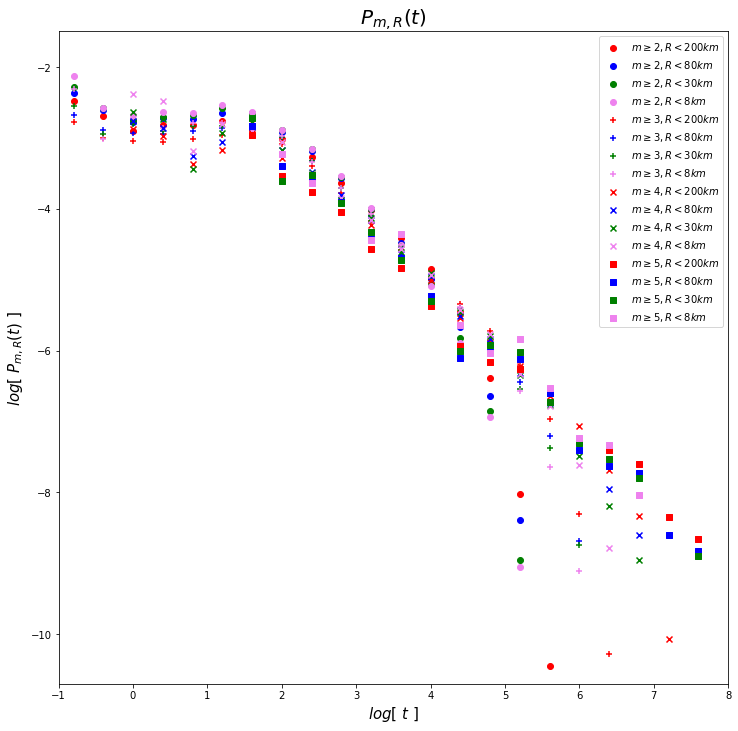

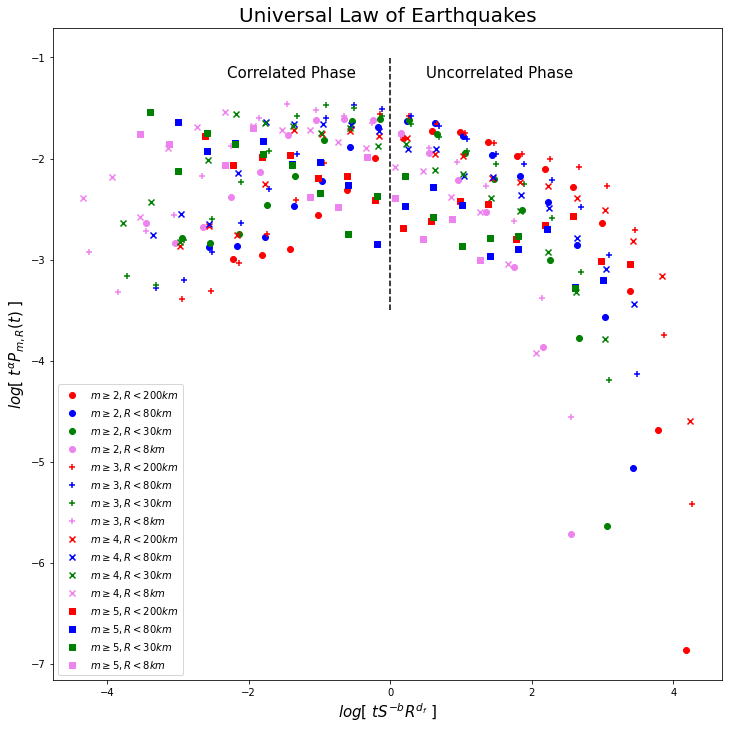

In [19]:
magth=np.arange(2,6,1)
Rth=np.array([200000,80000,30000,8000])
R=np.matrix([Rth[0]*np.ones(4),Rth[1]*np.ones(4),Rth[2]*np.ones(4),Rth[3]*np.ones(4)])
colors=['red','blue','green','violet'] # threshold R selected
markers=['o','+','x','s'] #corresponds to the number of magnitude selected (2,3,4,5)
Yu=[]
Xu=[]
b=G[0][1]
const=-4

fig6, ax6 = plt.subplots(figsize=(12,12))
fig7, ax7 = plt.subplots(figsize=(12,12))
 
for i in range(2):
    for j in range(2):
        for z in range(np.shape(R)[0]):
            mask=(df['mag']>=magth[s(i,j)])
            dr=df[mask]
            dr=dr.drop(columns=['t','pointer','mag','date'])
            dr['dpw']=((dr.diff()**2).sum(axis=1))**0.5 #dpw stay  for distance pairs waise
            dr.insert(loc=0, column='t', value=df['t'][dr.index])
            dr.insert(loc=1, column='dt', value=df['t'][dr.index])
            dr['dt']=dr['dt'].diff()
            dr=dr.drop(dr.index[0])
            dr=dr.drop(dr[dr['dpw'] > R[z,s(i,j)]].index)

            counts6, bins6, bars =ax6.hist(dr['dt'], visible=0,bins=np.logspace(-1,9,26),density=1) #-1,8 19  // -1,9 26
            yhb=counts6[counts6>0]
            yhb=yhb
            Yu=np.insert(Yu,0,yhb)
            xF=(bins6[:-1]*bins6[1:len(counts6)+1])**0.5
            xF=xF[counts6>0]
            Xu=np.insert(Xu,0,xF)
            ax6.scatter(np.log10(xF),np.log10(yhb),color=colors[z],marker=markers[s(i,j)],
                        label='$m\geq%s, R<%.0f km$'%(magth[s(i,j)],R[z,s(i,j)]/1000))

            Yt1=alpha[s(i,j)]*np.log10(xF)+np.log10(yhb)
            Xt1=np.log10(xF) + b*magth[s(i,j)] + dfv[s(i,j)]*np.log10(R[z,s(i,j)]) +const
            ax7.scatter(Xt1,Yt1,color=colors[z],marker=markers[s(i,j)],
                        label='$m\geq%s, R<%.0f km$'%(magth[s(i,j)],R[z,s(i,j)]/1000))

ax7.set_title('Universal Law of Earthquakes',size=20)
ax7.set_xlabel('$log[~tS^{-b}R^{d_{f}}~]$',size=15)
ax7.set_ylabel('$log[~t^{\\alpha}P_{m,R}(t)~]$',size=15)
ax7.plot(np.zeros(100),np.linspace(-3.5,-1,100),'k--')
ax7.text(0.5,-1.2, 'Uncorrelated Phase',size=15)
ax7.text(-2.3,-1.2, 'Correlated Phase',size=15)
ax7.legend(loc='best')

ax6.set_xlim(-1,8)
ax6.set_ylim(-10.7,-1.5)
ax6.set_title('$P_{m,R}(t)$',size=20)
ax6.set_xlabel('$log[~t~]$',size=15)
ax6.set_ylabel('$log[~P_{m,R}(t)~]$',size=15)
ax6.legend(loc='best');

### OBSERVATIONS

The last graph shows the so called "Universal Law of Earthquakes", that is a pattern manteined over 8 decades. 

As well described in the paper, the constant left part is related to a highly correlated region of power-law behavior, which corresponds to the Omori Law, in which a sequence of earthquakes are temporally correlated; the decaying right part of the graph for large $x$ is consistent with an exponential decay, indicating a random Poisson distribution of interoccurrence times and is indicative of earthquakes that would be classified as uncorrelated events and would be seen as responsible for creating the proceeding sequence of correlated earthquakes. 

A critical part of this analysis was to fix some proper values for the thresholds: fixing a large $R$ in fact $P_{m,R}(t)$ becomes the previous $P_{m}(t)$ studied before, and in some sense choosing $R$ means that we are select the area of interest of the study.

# Bibliography

This study is based on "Unified scaling law for earthquakes" from Kim Christensen, Leon Danon, Tim Scanlon, and Per Bak. \
The paper can be found at the following link: https://www.pnas.org/content/pnas/99/suppl_1/2509.full.pdf